In [51]:
import numpy as np
import re
import scipy.io as spio
import math
import matplotlib.pyplot as plt
import statistics

from scipy.signal import medfilt
from scipy.interpolate import interp1d
%matplotlib notebook

In [43]:
def readTextTable(file_name, head_lines=0, cmpl=False):
    e = ''
# Check comsol text file ------------------------------------------------------
    try:
        f = open(file_name, "r")
    except IOError:
        e = ("Error! Cannot open file ""%s"" !") % file_name
        Data = np.array([], float)
        return (Data,e)
    #end_try
# -----------------------------------------------------------------------------

# Read data from file ---------------------------------------------------------
    lines_all = f.readlines()                                                   # read all string lines in the file and save to the list 'lines_all'
    f.close()

    str_list = re.split('\s+', lines_all[head_lines])                           # split line into 'words'
    str_list = list(filter(None, str_list))                                     # remove '' from the list

    cols = len(str_list)
    rows = len(lines_all)-head_lines

    Data = np.zeros((rows, cols), complex)                                   # allocate memory for data

    line_idx = head_lines
    i = 0
    for line in lines_all[head_lines:]:
        str_list = re.split('\s+', line.replace('i', 'j'))                      # split line into 'words'
        str_list = list(filter(None, str_list))                                 # remove '' from the list
        try:                                                                    # check whether all words in the line are numeric values
            data_list = [complex(s) for s in str_list]
        except (ValueError, IndexError):
            e += "Incorrect data in line %d !" % (line_idx)
            if not cmpl: Data = np.real(Data)
            return (Data,e)
        #end_try

        if len(data_list) == cols:
            Data[i,:] = np.array(data_list, complex)
        else:
            e += "Incorrect data in line %d !" % (line_idx)
            if not cmpl: Data = np.real(Data)
            return (Data,e)
        #end_if

        i += 1
        line_idx += 1
    #end_for

    if not cmpl: Data = np.real(Data)
    return (Data,e)


def dBToPow(data):
    return 10**(data/10)


## Сырой формат данных

In [3]:
fname_lfp = r"C:\TGT\1.02.2022\Averaging_SNL10a_1461_24.11.2021-LFP.txt"
fname_hfp = r"C:\TGT\1.02.2022\Averaging_SNL10a_1461_24.11.2021-HFP.txt"

In [107]:
Q = [0, 0, 15, 5, 10.3, 15.2, 17.2, 10.7, 22.7, 30.5, 40.6, 50.2, 61.6, 70, 79.7, 92, 103.3, 123.8, 141.4, 160 ]
Q = np.array(Q, float)

# Read signal + background + resonant noise data (LFP)
raw_lfp,_ = readTextTable(fname_lfp)

freq_lfp = raw_lfp[0,:]
raw_lfp = raw_lfp[1:,:].squeeze()


# Read signal + background + resonant noise data (HFP)
raw_hfp,_ = readTextTable(fname_hfp)

freq_hfp = raw_hfp[0,:]
raw_hfp = raw_hfp[1:,:].squeeze()

qc_idx = [True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True]
Q = Q[qc_idx]
raw_hfp = raw_hfp[qc_idx]
raw_lfp = raw_lfp[qc_idx]


rate_idx = np.argsort(Q)
raw_hfp = raw_hfp[rate_idx]
raw_lfp = raw_lfp[rate_idx]
Q = Q[rate_idx]

raw_lfp = dBToPow(raw_lfp)
raw_lfp_bkg = raw_lfp[1,:] 
raw_lfp = raw_lfp[1:,:]
raw_hfp = dBToPow(raw_hfp)   
raw_hfp_bkg = raw_hfp[1,:] 
raw_hfp = raw_hfp[1:,:]
Q = Q[1:]


stations = len(Q)
lfp = raw_lfp - np.tile(raw_lfp_bkg, [stations,1])
hfp = raw_hfp - np.tile(raw_hfp_bkg, [stations,1])

idx_4kHz = freq_hfp >= 4.0 
hfp = hfp[:,idx_4kHz]

freq_lfp_new = freq_hfp[freq_hfp < 4.0]
interp = interp1d(freq_lfp, lfp)
lfp_new = interp(freq_lfp_new)

hfp_new = np.hstack((lfp_new, hfp))


512

## 1-й этап
### Фильтрация медианой с окошком 17 точек, при длительности 1-го эксперимента 512 точек 

<IPython.core.display.Javascript object>


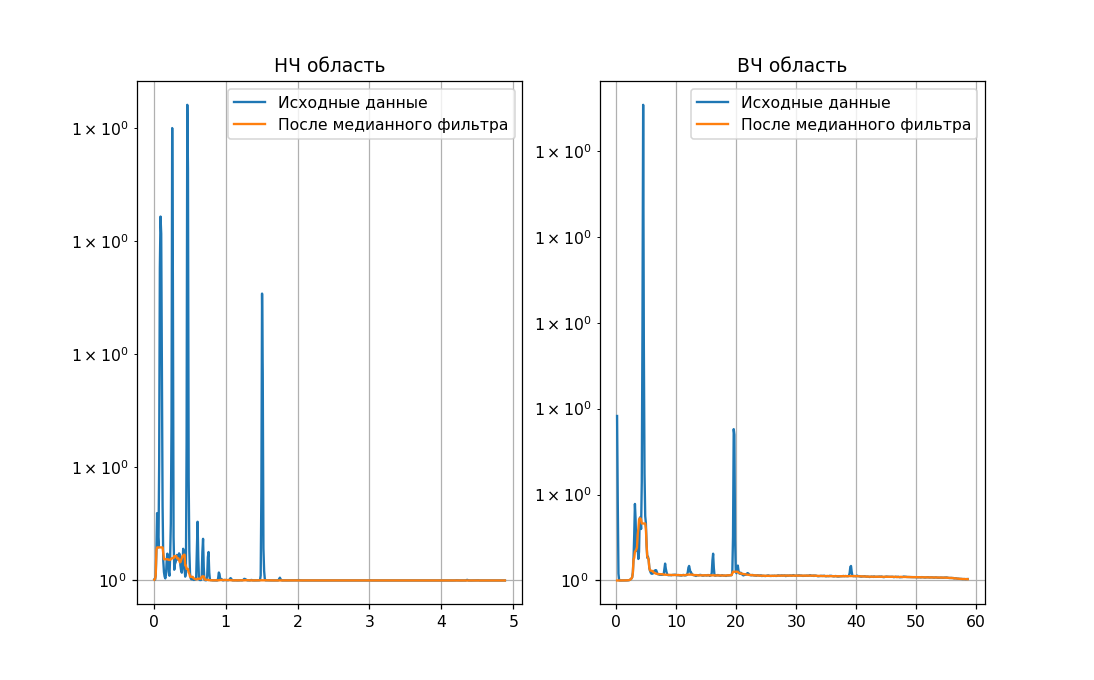

In [122]:
fig, (ax1,ax2) = plt.subplots(1, 2)

ax1.plot(freq_lfp, dBToPow(raw_lfp[1]), label='Исходные данные')
ax1.plot(freq_lfp, medfilt(dBToPow(raw_lfp[1]), 17), label='После медианного фильтра')
ax1.set_yscale('log')
ax1.set_title('НЧ область')
ax1.grid()
ax1.legend()

ax2.plot(freq_hfp, dBToPow(raw_hfp[1]), label='Исходные данные')
ax2.plot(freq_hfp, medfilt(dBToPow(raw_hfp[1]), 17), label='После медианного фильтра')
ax2.set_yscale('log')
ax2.set_title('ВЧ область')
ax2.grid()
ax2.legend()

